In [1]:
import os
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from scipy.fft import fftfreq
from spectrum import arma2psd

import torch
from torch import nn
import torchvision

from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from timescales.autoreg import compute_ar_spectrum
from timescales.fit import PSD

## Rotaion Invariant Simultaneous Autoregressive Model

A circle of AR coefficients may be solved, providing a rotation invaraint spatial AR model. See:

Jianchang Mao, Anil K. Jain, Texture classification and segmentation using multiresolution simultaneous autoregressive models,
Pattern Recognition, Volume 25, Issue 2, 1992, Pages 173-188, ISSN 0031-3203, https://doi.org/10.1016/0031-3203(92)90099-5.

In [2]:
# Taken from https://stackoverflow.com/questions/8661537/how-to-perform-bilinear-interpolation-in-python
#   Relatively fast, but still is likely a computational bottleneck
import numpy as np
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
from numba import jit, prange

@jit(nopython=True, fastmath=True, nogil=True, cache=True, parallel=True)
def bilinear_interpolation(x_in, y_in, f_in, x_out, y_out):
    f_out = np.zeros((y_out.size, x_out.size))
    
    #for i in prange(f_out.shape[1]):
    for i in range(f_out.shape[1]):
        idx = np.searchsorted(x_in, x_out[i])
        
        x1 = x_in[idx-1]
        x2 = x_in[idx]
        x = x_out[i]
        
        for j in prange(f_out.shape[0]):
            
            idy = np.searchsorted(y_in, y_out[j])
            
            y1 = y_in[idy-1]
            y2 = y_in[idy]
            y = y_out[j]

            f11 = f_in[idy-1, idx-1]
            f21 = f_in[idy-1, idx]
            f12 = f_in[idy, idx-1]
            f22 = f_in[idy, idx]
        
            f_out[j, i] = ((f11 * (x2 - x) * (y2 - y) +
                            f21 * (x - x1) * (y2 - y) +
                            f12 * (x2 - x) * (y - y1) +
                            f22 * (x - x1) * (y - y1)) /
                           ((x2 - x1) * (y2 - y1)))
    
    return f_out

In [3]:
@jit(nopython=True, fastmath=True, nogil=True, cache=True, parallel=True)
def interpolate_circle(img, n_points, radius, center):

    # Generate theta values evenly spaced between 0 and 2*pi
    theta_values = np.linspace(0, 2*np.pi, n_points)
    
    # Calculate the corresponding x and y values
    x_circle = np.cos(theta_values)
    y_circle = np.sin(theta_values)
    
    # Normalize to d=1 and c=0
    x_circle = (x_circle - x_circle.min())
    x_circle = (x_circle / x_circle.max()) - 0.5
    
    y_circle = y_circle - y_circle.min()
    y_circle = (y_circle / y_circle.max()) - 0.5

    # Original image
    h = len(img)
    w = len(img[0])
    x1 = np.arange(0, w).astype(np.float64)
    y1 = np.arange(0, h).astype(np.float64)
    
    # Rescale circle to size radius
    x2 = (x_circle*(radius*2)) + center[0]
    y2 = (y_circle*(radius*2)) + center[1]
    
    # Interpolate
    interp_vals = np.diag(bilinear_interpolation(x1, y1, img, x2, y2))

    return x2, y2, interp_vals

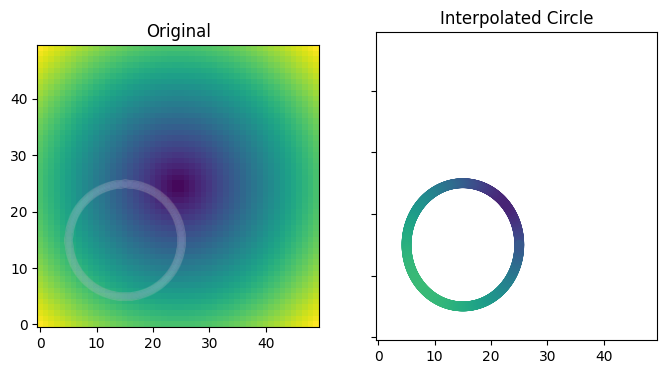

In [4]:
# Example demonstration of interpolating along a circle
#   Checks to confirm interpolation is correct on a simulated input
x_axis = np.linspace(-1, 1, 50)[:, None]
y_axis = np.linspace(-1, 1, 50)[None, :]

inner = np.array([0, 0, 0])[None, None, :]
outer = np.array([1, 1, 1])[None, None, :]

arr = np.sqrt(x_axis ** 2 + y_axis ** 2)
arr /= arr.max()
arr = arr[:, :, None]
arr = (arr * outer + (1 - arr) * inner)[:, :, 0]

# Interpolate
img = arr
n_points = 1000
radius = 10
center = (15, 15)
x2, y2, interp_vals = interpolate_circle(img, n_points, radius, center)

# Plot
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), sharey=True, sharex=True)

ax0im = axes[0].imshow(img, origin='lower')
ax0im.set_clim(0, 1)
axes[0].scatter(x2, y2, color='white', alpha=.01)

ax1im = axes[1].scatter(x2, y2, c=interp_vals)
ax1im.set_clim(0, 1)

axes[0].set_title('Original')
axes[1].set_title('Interpolated Circle');

## Circular Grid

An AR model is solved across each circle below. Moving the circle across the image protects against translations in the image. The circle protext against rotations. Scale invariance is not protect against here, e.g. zooming in or out will cause issues. This could involve learning optimal circle radii per image.

Once the AR coefficients are learned, they may be used to compute power spectral density.

Text(0.5, 1.0, 'Circular AR')

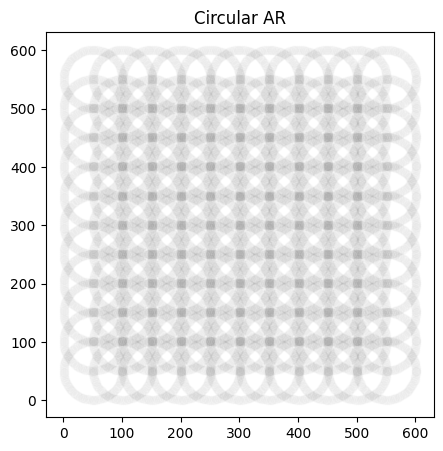

In [5]:
plt.figure(figsize=(5, 5))
img = np.ones((576, 576))
radius = 50
n_points = 100

for ix in np.arange(radius+1, len(img), 50):
    for iy in np.arange(radius+1, len(img[0]), 50):
        center = (ix, iy)
        x2, y2, _ = interpolate_circle(img, n_points, radius, center)
        plt.scatter(x2, y2, color='k', alpha=.01)
    
plt.title('Circular AR')

### Textures

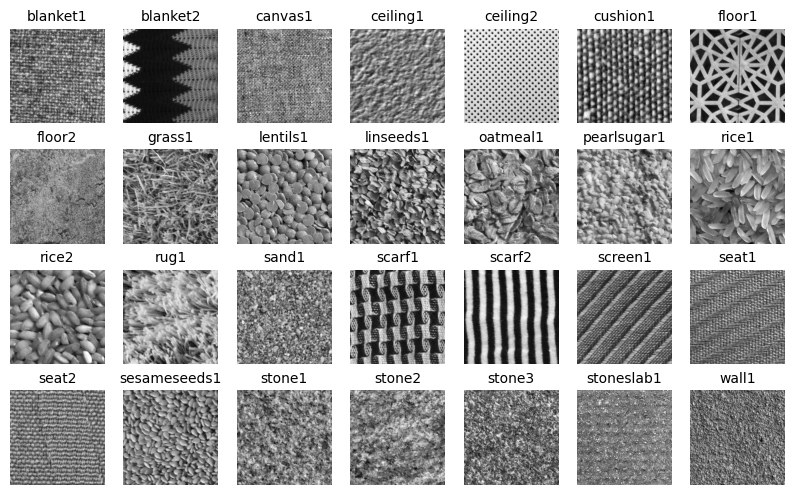

In [6]:
# Load
base_dir = "texture/kylberg"

f = os.listdir(base_dir)
f.sort()
f = [i for i in f if i.endswith('.png')]

classes = [i.split('-')[0].split('.')[0] for i in f]
classes = np.unique(classes)

y = np.arange(len(classes))

classes = {c:int(i) for c, i in zip(classes, y)}
n_classes = len(classes)

# Data and labels
X = torch.zeros(len(f), 576, 576)
y = torch.zeros(len(f))

for i in range(len(f)):
    X[i] = torchvision.io.read_image(f"{base_dir}/{f[i]}")[0]
    y[i] = classes[f[i].split('-')[0].split('.')[0]]

# Plot examples
fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(10, 6))
axes = axes.flatten()

for c in classes.keys():
    i = classes[c]
    axes[i].imshow(X[np.where(y == i)[0][0]], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(c, size=10)

### Solve AR

In [7]:
# Neutral network for solving AR
class AR(nn.Module):

    def __init__(self, size):
        super().__init__()
        #self.w = nn.Parameter(torch.rand(size)/2)
        self.w = nn.Parameter(torch.zeros(size) + torch.rand(size)/10)

    def forward(self, x):
        return x @ self.w 

def train_ar(x_ar, y_ar, index):
    
    X_train = torch.tensor(x_ar.astype(np.float32))
    y_train = torch.tensor(y_ar.astype(np.float32))
    
    #X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
    #y_train = (y_train - y_train.mean()) / y_train.std()

    model = AR(len(X_train[0]))
    
    loss_fn = nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    n_epochs = 100
    batch_size = 200
    
    for i_epoch in tqdm(range(n_epochs), total=n_epochs):
    
        permutation = torch.randperm(len(X_train))
        
        for i_batch in range(0, len(X_train), batch_size):
            
            indices = permutation[i_batch:i_batch+batch_size]
            X_batch, y_batch = X_train[indices], y_train[indices]
        
            out = model(X_batch)
            loss = loss_fn(out, y_batch)
            loss.backward()
            
            opt.step()
            opt.zero_grad()

    y_pred_train = model(X_train)
    loss_train = float(loss_fn(y_pred_train, y_train))
    print(f"{index} final loss: {loss_train}")
    
    # Save model
    torch.save(model, f"ar_texture/model_{str(index).zfill(4)}.pkl")

    # Return ar coefficients
    ar_coefs = model.w.detach().numpy()
    
    return ar_coefs

In [8]:
from itertools import product

def ar_reshape(x, size):
    x_ar = np.lib.stride_tricks.sliding_window_view(x, size, axis=1)[:, :-1]
    x_ar = x_ar.reshape(-1, size)
    y_ar = x[:, size:].reshape(-1, 1)
    return x_ar, y_ar

In [9]:
# Grid of interpolation circle parameters
radius = 50
n_points = 1000
spacing = 50

ix = np.arange(radius+1, len(X[0][0]), spacing)
iy = np.arange(radius+1, len(X[0]), spacing)

grid = np.array(list(product(ix, iy)))

In [ ]:
# Takes 20 ish hours to run on an M1
ar_order = 20
ar_coefs = np.zeros((len(X), ar_order))

for ix, x in enumerate(X):

    x = (x-x.mean()) / x.std()
    
    X_interp = np.zeros((len(grid), n_points))

    for i, g in enumerate(grid):
        center = (g[0], g[1])
        _, _, X_interp[i] = interpolate_circle(x.numpy(), n_points, radius, center)

    x_ar, y_ar = ar_reshape(X_interp, ar_order)

    ar_coefs[ix] = train_ar(x_ar, y_ar[:, 0], ix)

In [10]:
# Reload torch models
fmodels = os.listdir("ar_texture")
fmodels.sort()

In [11]:
from scipy.fft import fftfreq
from spectrum import arma2psd

def ar_to_psd(ar_coefs, nfft):
    # Convert ar to psd
    fs = 100
    
    powers = arma2psd(A=-ar_coefs[::-1], rho=1., T=fs, NFFT=nfft)
    freqs = fftfreq(nfft, 1/fs)
    powers = powers[:len(freqs)//2]
    freqs = freqs[:len(freqs)//2]
    
    freqs = freqs[1:]
    powers = powers[1:]

    return freqs, powers

In [12]:
X_ar = []
y_ar = []

for i, f in enumerate(fmodels):
    m = torch.load("ar_texture/" + f)
    ar_coefs = m.w.detach().numpy()
    
    if np.isnan(ar_coefs[0]):
        continue

    freqs, powers = ar_to_psd(ar_coefs, nfft=500)
    
    X_ar.append(powers)
    y_ar.append(int(y[i]))

X_ar = np.log10(np.array(X_ar))
y_ar = np.array(y_ar)

X_ar.shape, y_ar.shape

((4311, 249), (4311,))

## Modeling

SVM to predict class.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X_ar, y_ar, train_size=0.8)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

svc = SVC()
svc.fit(X_train, y_train)

print('Accuracy: ', (svc.predict(X_test) == y_test).sum() / len(y_test))

Accuracy:  0.8702201622247973


In [31]:
# Load
base_dir = "texture/kylberg"

f = os.listdir(base_dir)
f.sort()
f = [i for i in f if i.endswith('.png')]

classes = [i.split('-')[0].split('.')[0] for i in f]
classes = np.unique(classes)

y = np.arange(len(classes))

classes = {c:int(i) for c, i in zip(classes, y)}
n_classes = len(classes)

# Data and labels
X = torch.zeros(len(f), 576, 576)
y = torch.zeros(len(f))

for i in range(len(f)):
    X[i] = torchvision.io.read_image(f"{base_dir}/{f[i]}")[0]
    y[i] = classes[f[i].split('-')[0].split('.')[0]]

In [ ]:
# Undo rescaling for plotting
X_train, X_test, y_train, y_test = train_test_split(X_ar, y_ar, train_size=0.8)

fig, axes = plt.subplots(nrows=n_classes+1, ncols=n_classes+1, figsize=(20, 20))

for ax, c in zip(axes[0][1:], classes.keys()):
    i = classes[c]
    ax.imshow(X[np.where(y == i)[0][0]], cmap='gray')
    ax.axis('off')


for ax, c in zip(axes[:, 0][1:], classes.keys()):
    i = classes[c]
    ax.imshow(X[np.where(y == i)[0][0]], cmap='gray')
    ax.axis('off')


for i in range(n_classes):
    for j in range(n_classes):
        
        if i == j:
            continue

        
        for x, y in zip(X_test, y_test):

            if y == i:
                axes[i+1, j+1].loglog(freqs, 10**x, color='C0', alpha=.25)
                axes[j+1, i+1].loglog(freqs, 10**x, color='C0', alpha=.25)
            elif y == j:
                axes[i+1, j+1].loglog(freqs, 10**x, color='C1', alpha=.25)
                axes[j+1, i+1].loglog(freqs, 10**x, color='C1', alpha=.25)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig('psd.png')